<h1 style="font-size:30px;">Training the ASL Classifier using VGG-16 (Transfer Learning + Fine Tuning)</h1>  

In this notebook, we implement a hybrid approach to **transfer learning** where we use pre-trained weights for the first layers of the feature extractor, and train the weights for the last layers of the feature extractor, as well as the full connected layers of the classifer. This approach is called **fine-tuning** because it makes small adjustments to the more abstract representations of the model being reused to make them more relevant for the problem at hand.

**The fine-tuning technique is summarized below:**

1. Instantiate the VGG-16 convolutional base with pre-trained weights from ImageNet
2. Configure the convolutional base as "trainable"
3. Freeze all the layers in the convolutional base (EXCEPT the last four)
4. Add our custom classifier layer for the ASL dataset
5. Train the model (the last four layers of the feature extractor, plus the classifier)

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_06_asl_fine_tuning.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Training the Model with Fine-Tuning](#4-Training-the-Model-with-Fine-Tuning)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

2023-05-08 06:57:48.863016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 06:57:48.989345: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("tensorflow version : ",tf.__version__)
print("tensorflow version : ",keras.__version__)
print("opencv version : ",cv2.__version__)

tensorflow version :  2.10.0
tensorflow version :  2.10.0
opencv version :  4.6.0


## 1 System Configuration

In [3]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Download and Extract the Dataset

In [4]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [5]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [6]:
#download_file(
#    'https://github.com/AlbertaBeef/asl_tutorial/releases/download/vitis_ai_3.0_version2/dataset_ASL_reduced.zip?dl=1', 
#    'dataset_ASL_reduced.zip'
#)
    
#unzip(zip_file='dataset_ASL_reduced.zip')

## 3 Dataset and Training Configuration

In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 29
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    TRAINING_DATA_ROOT:   str = './dataset_ASL_reduced/training'
    VALIDATION_DATA_ROOT:   str = './dataset_ASL_reduced/validation'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0005
    CHECKPOINT_DIR: str   = './saved_models_asl_classifier23'

## 4 Training the Model with Fine-Tuning

The Keras API provides the following utility that is used to instantiate a VGG-16 model, which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset** as a starting point for **Fine-Tuning.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>

```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_01_imagenet.png' width=1000 align='center'><br/>


In [8]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Create a MobileNetV2 model along with the imagenet pre-trained weights.')
mobilenetv2_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=True,
                                                alpha=0.5,
                                                weights='imagenet',
                                               )

Create a MobileNetV2 model along with the imagenet pre-trained weights.


2023-05-08 06:57:51.125162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(mobilenetv2_model.summary())

Model: "mobilenetv2_0.50_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_



### 4.1 VGG Convolutional Base
We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False`, which excludes the fully connected layers. In this notebook, we will instantiate the model with weights that were learned by training the model on the ImageNet dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_10_pretrained_base.png' width=1000 align='center'><br/>


In [10]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Create a MobileNetV2 model along with the imagenet pre-trained weights.')
mobilenetv2_model_base = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                    include_top=False,
                                                    alpha=0.5,                                                           
                                                    weights='imagenet',
                                                   )


Create a MobileNetV2 model along with the imagenet pre-trained weights.


In [11]:
print(mobilenetv2_model_base.summary())

Model: "mobilenetv2_0.50_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### 4.2 Freeze all but the Last Four Layers for Fine-Tuning

In the previous section, we set the `trainable` attribute of the convolutional base to `True`. This now allows us to "freeze" a selected number of layers in the convolutional base so that only the last few layers in the convolutional base are trainable. 

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_11_freeze_layers.png' width=1000 align='center'><br/>

#### How to freeze only a few layers?
There are two ways to specify which layers in the model are trainable (tunable). 
1. We can start by making the entire convolutional base trainable by setting the `trainable` flag to `True`. Then loop over the **initial** layers and make them untrainable by setting the same (`trainable`) flag for each layer to `False`. 

2. We can freeze the entire convolutional base by setting the `trainable` flag to `False`, and then loop over the  **last** few layers and set the `trainable` flag to `True`.

We use the first approach in this notebook. In the code cell below, we start by setting the entire convolutional base as "trainable" by settng the `trainable` attribute to `True`.

In [12]:
# First make the convolutional base trainable.
#mobilenetv2_model_base.trainable = True
#print('All weights trainable, fine tuning ...')

#print('Freeze the weights of the layers that we are not training')
#for layer in mobilenetv2_model_base.layers[:-4]:
#    layer.trainable = False

In [13]:
# Freeze the convolutional base
mobilenetv2_model_base.trainable = True
print('All weights trainable, transfer learning ...')

All weights trainable, transfer learning ...


In [14]:
print(mobilenetv2_model_base.summary())

Model: "mobilenetv2_0.50_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### 4.3 Add the Classification Layer
Since we intend to train and use the model to classify hand signals from the ASL dataset (which has 29 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 29 nodes for each of the 29 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset.

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_12_add_classifier.png' width=1000 align='center'><br/>

In [15]:
print('Add Classification Layers (output or top)')
# Take the output of the MobileNetV2 before last layers
x = mobilenetv2_model_base.layers[-4].output

x = tf.keras.layers.Conv2D(filters = 1000,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
x = tf.keras.layers.BatchNormalization(name='last_bn')(x)
x = tf.keras.layers.ReLU(6,name='last_relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool')(x)
predictions = tf.keras.layers.Dense(DatasetConfig.NUM_CLASSES,activation='softmax')(x)

model = tf.keras.Model(inputs=mobilenetv2_model_base.input, outputs=predictions)

Add Classification Layers (output or top)


In [16]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### 4.4 Prepare the Training and Validation Dataset

In [17]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.TRAINING_DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.VALIDATION_DATA_ROOT,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                            )

Found 5800 files belonging to 29 classes.
Found 1450 files belonging to 29 classes.


### 4.4.1 Normalizing the Datasets

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [20]:
normalized_valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

### 4.5 Display Sample Images

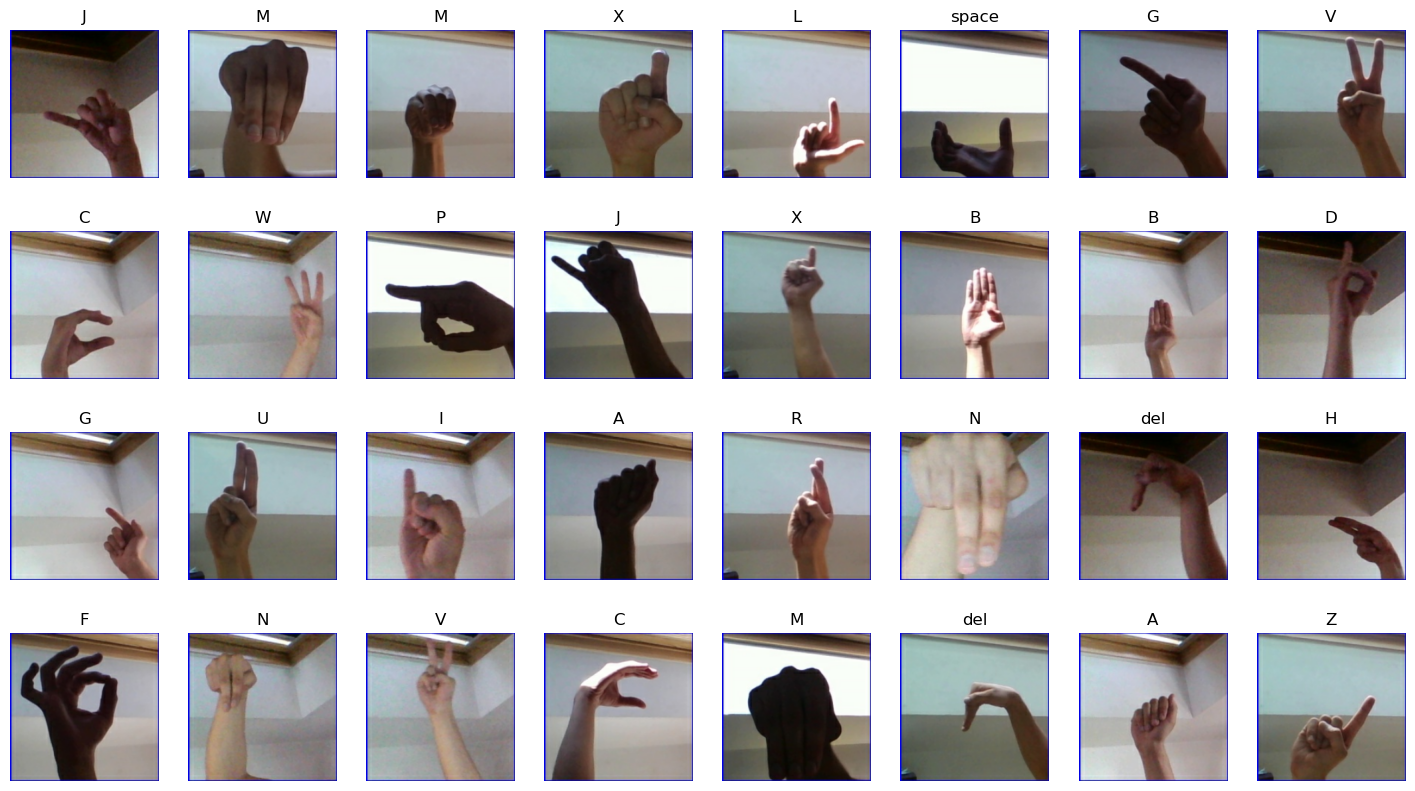

In [21]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.6 Compile and Train the Model

<img src='https://github.com/AlbertaBeef/asl_tutorial/raw/2022.2/images/MobileNetV2_06_asl_fine_tuning.png' width=1000 align='center'><br/>

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [23]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

In [24]:
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 12s 213ms/step - loss: 3.7325 - accuracy: 0.0269
Model evaluation accuracy: 2.690


In [25]:
print(f"Model evaluation accuracy: {model.evaluate(normalized_valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 9s 202ms/step - loss: 3.6867 - accuracy: 0.0366
Model evaluation accuracy: 3.655


In [26]:
from datetime import datetime

# datetime object containing current date and time
timestamp1 = datetime.now()
print(timestamp1)

2023-05-08 06:58:18.551903


In [27]:
# Train the Model.
training_results = model.fit(normalized_train_dataset,#train_dataset,
                                   validation_data=normalized_valid_dataset,#valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
182/182 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.8598

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 126s 667ms/step - loss: 0.6151 - accuracy: 0.8598 - val_loss: 1.9255 - val_accuracy: 0.4634
Epoch 2/51
182/182 [==============================] - 90s 492ms/step - loss: 0.0439 - accuracy: 0.9917 - val_loss: 2.2876 - val_accuracy: 0.3366
Epoch 3/51
182/182 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9960

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 665ms/step - loss: 0.0206 - accuracy: 0.9960 - val_loss: 1.1954 - val_accuracy: 0.6414
Epoch 4/51
182/182 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9938

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 663ms/step - loss: 0.0280 - accuracy: 0.9938 - val_loss: 1.1529 - val_accuracy: 0.6428
Epoch 5/51
182/182 [==============================] - 89s 491ms/step - loss: 0.0263 - accuracy: 0.9940 - val_loss: 2.1984 - val_accuracy: 0.4945
Epoch 6/51
182/182 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9971

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 122s 670ms/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 0.8047 - val_accuracy: 0.7628
Epoch 7/51
182/182 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9952

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 668ms/step - loss: 0.0235 - accuracy: 0.9952 - val_loss: 0.8685 - val_accuracy: 0.7731
Epoch 8/51
182/182 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9976

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 665ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.3714 - val_accuracy: 0.9069
Epoch 9/51
182/182 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9995

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 122s 669ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.1839 - val_accuracy: 0.9628
Epoch 10/51
182/182 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 664ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 11/51
182/182 [==============================] - ETA: 0s - loss: 8.7404e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 122s 669ms/step - loss: 8.7404e-04 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9945
Epoch 12/51
182/182 [==============================] - ETA: 0s - loss: 6.1931e-04 - accuracy: 0.9998

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 665ms/step - loss: 6.1931e-04 - accuracy: 0.9998 - val_loss: 0.0162 - val_accuracy: 0.9979
Epoch 13/51
182/182 [==============================] - ETA: 0s - loss: 3.9298e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 668ms/step - loss: 3.9298e-04 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9986
Epoch 14/51
182/182 [==============================] - 90s 493ms/step - loss: 2.4965e-04 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9986
Epoch 15/51
182/182 [==============================] - 89s 487ms/step - loss: 2.1861e-04 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9986
Epoch 16/51
182/182 [==============================] - 89s 491ms/step - loss: 2.0778e-04 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9986
Epoch 17/51
182/182 [==============================] - 90s 492ms/step - loss: 1.6488e-04 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9986
Epoch 18/51
182/182 [==============================] - 89s 491ms/step - loss: 0.0335 - accuracy: 0.9928 - val_loss: 8.7534 - val_accuracy: 0.1834
Epoch 19/51
182/182 [==============================] - 89s 490ms/step - loss: 0.1022 - accuracy: 0.9712 - val_loss:

INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


INFO:tensorflow:Assets written to: ./saved_models_asl_classifier23/assets


182/182 [==============================] - 121s 667ms/step - loss: 2.6948e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9993
Epoch 31/51
182/182 [==============================] - 89s 491ms/step - loss: 2.1895e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 32/51
182/182 [==============================] - 89s 488ms/step - loss: 0.0764 - accuracy: 0.9779 - val_loss: 5.4252 - val_accuracy: 0.3821
Epoch 33/51
182/182 [==============================] - 89s 489ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.9483 - val_accuracy: 0.8193
Epoch 34/51
182/182 [==============================] - 89s 489ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0987 - val_accuracy: 0.9731
Epoch 35/51
182/182 [==============================] - 89s 488ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0326 - val_accuracy: 0.9952
Epoch 36/51
182/182 [==============================] - 89s 490ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.1552 - va

In [28]:
timestamp2 = datetime.now()
print(timestamp2)

print(timestamp2-timestamp1)

2023-05-08 08:20:35.560655
1:22:17.008752


### 4.7 Plot the Training Results

In [29]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

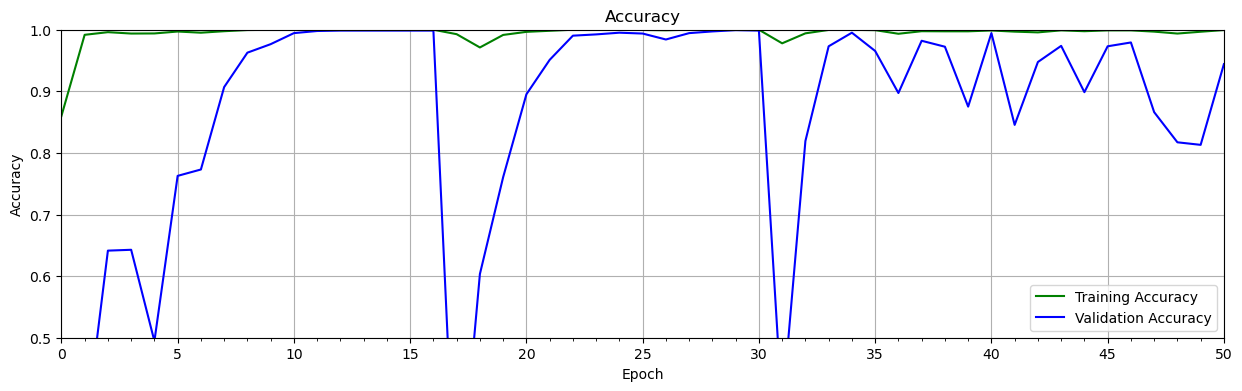

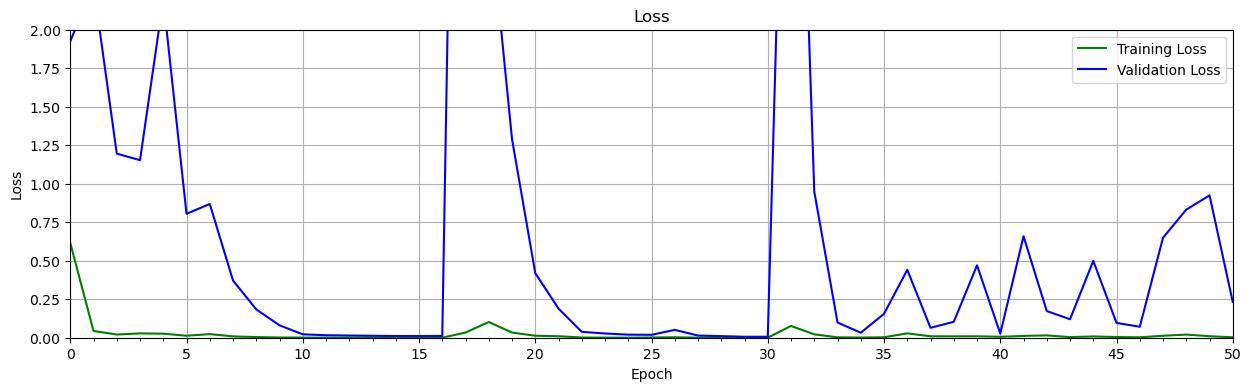

In [30]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.5, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

**Save model**

Once we are happy with the performance of the model, we can save it as a .h5 file, simply using the `save` method.

In [31]:
print(model.summary())
model.save('tf2_asl_classifier23.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 96)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 96)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 96)  864         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 192)  6144        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 192)  768        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 192)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 192)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 48)   9216        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 48)  192         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 288)  13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 480)   4320        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 480)   1920        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

**Load model**

Load model for the rest of the tutorial with the `load_model` method.

In [32]:
model = keras.models.load_model('tf2_asl_classifier23.h5')

## 5 Model Evaluation

### 5.1 Evaluate Accuracy

In [33]:
# Final evaluation accuracy on the validation set.
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 10s 203ms/step - loss: 6.1518 - accuracy: 0.2379
Model evaluation accuracy: 23.793


In [34]:
print(f"Model evaluation accuracy: {model.evaluate(normalized_valid_dataset)[1]*100.:.3f}")

46/46 [==============================] - 9s 205ms/step - loss: 0.2320 - accuracy: 0.9441
Model evaluation accuracy: 94.414


### 5.2 Display Confusion Matrix

In [35]:
!pip3 install seaborn

Generating Predictions...


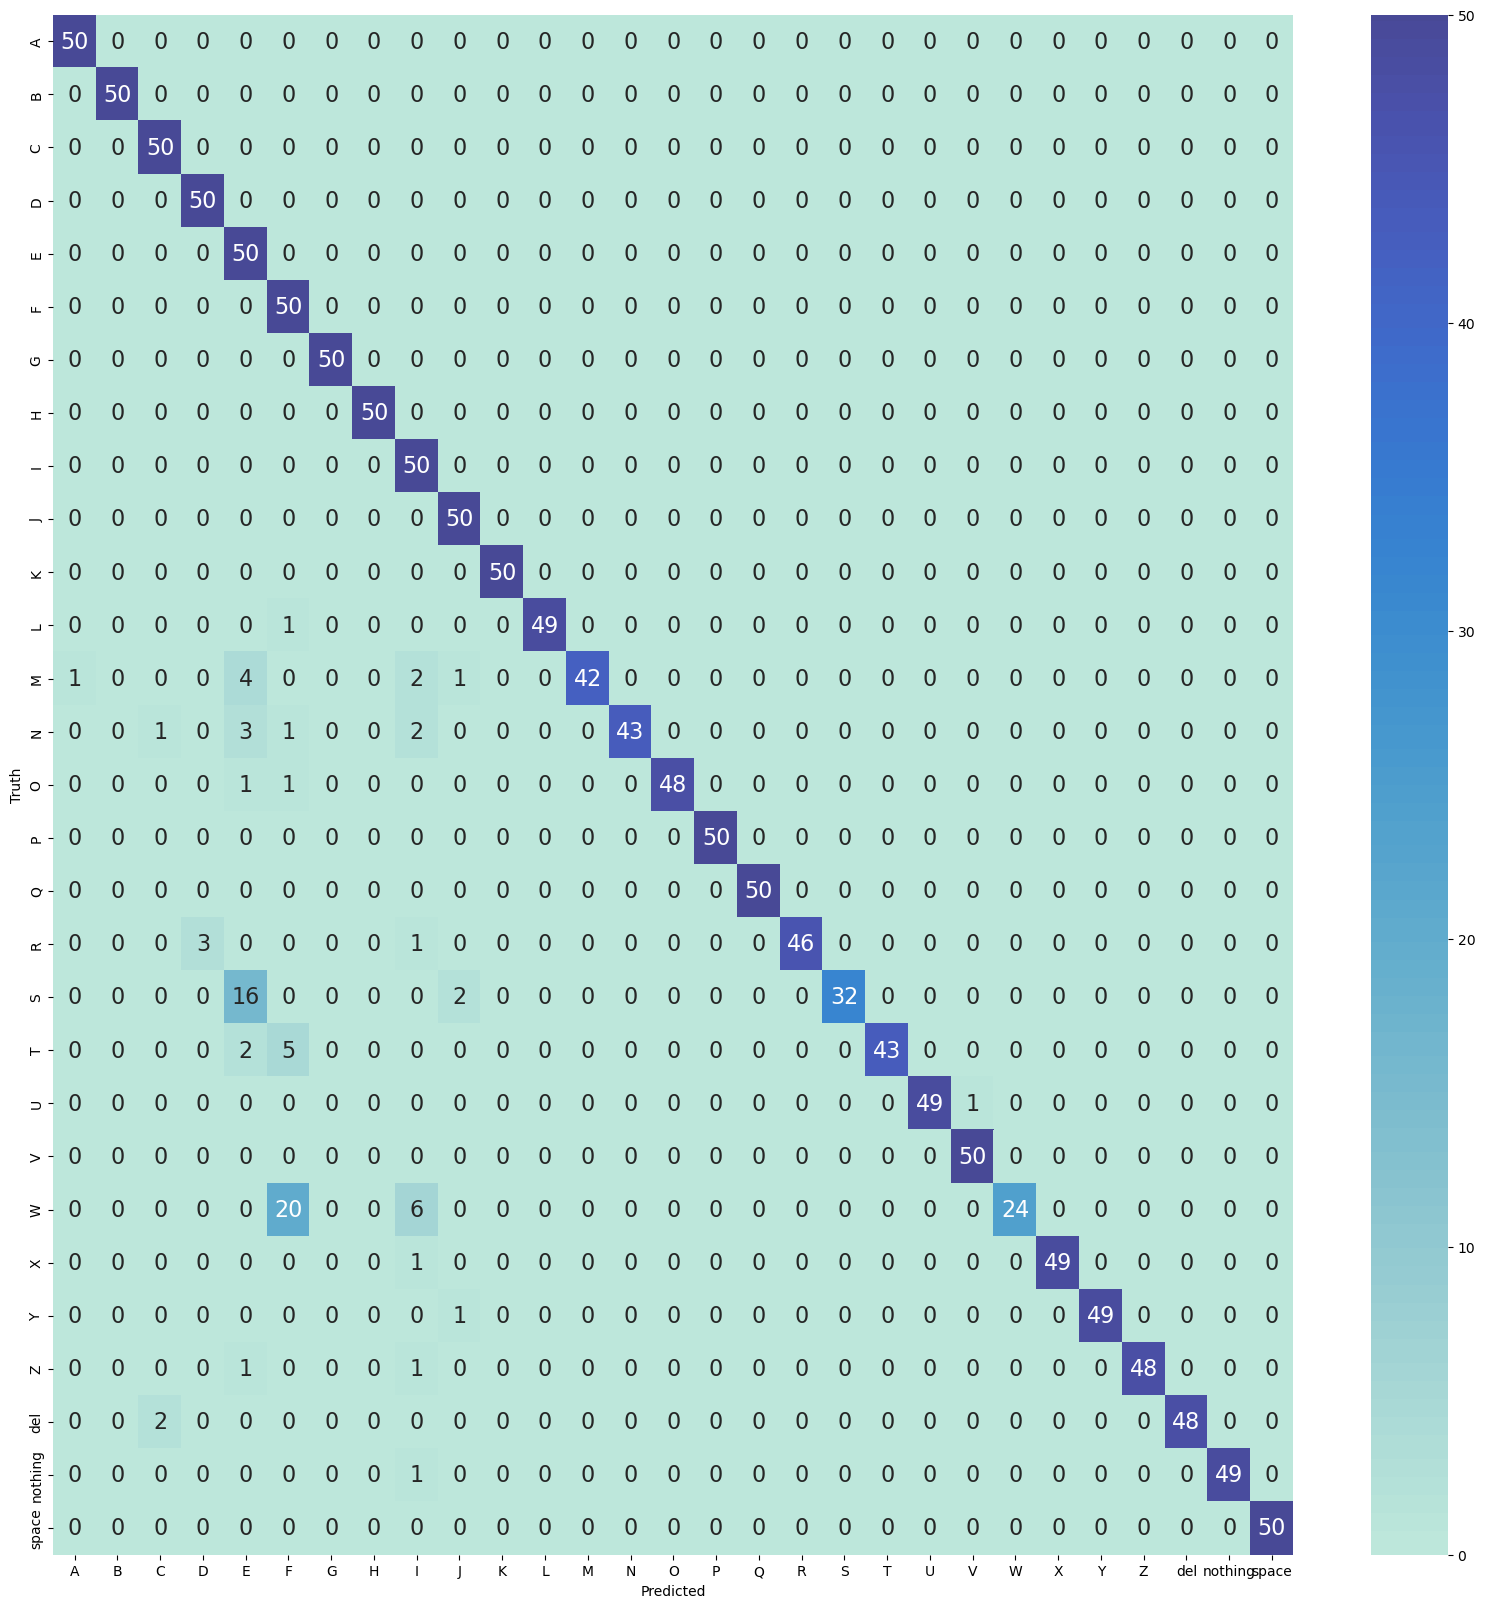

In [36]:
# reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sn

class_names = valid_dataset.class_names

ground_truths = []
predictions = []

print("Generating Predictions...")
#for data, target in valid_dataset:
for data, target in normalized_valid_dataset:
    model_predictions = model.predict_on_batch(data)
    cls_predicted = np.argmax(model_predictions, axis=-1)
    cls_probs = np.max(model_predictions, axis=-1)

    predictions.extend(cls_predicted)
    
    cls_ground_truth = np.argmax(target, axis=-1)
    ground_truths.extend(cls_ground_truth)

confusion_matrix = tf.math.confusion_matrix(ground_truths, predictions)

plt.figure(figsize=[20, 20])
sn.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={"size": 16},center=80)
plt.xlabel('Predicted')
plt.ylabel('Truth')
ax = plt.gca()
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.show()


## 5.3 Display Incorrect Predictions

In [37]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return  

1/1 [==============================] - 1s 832ms/step


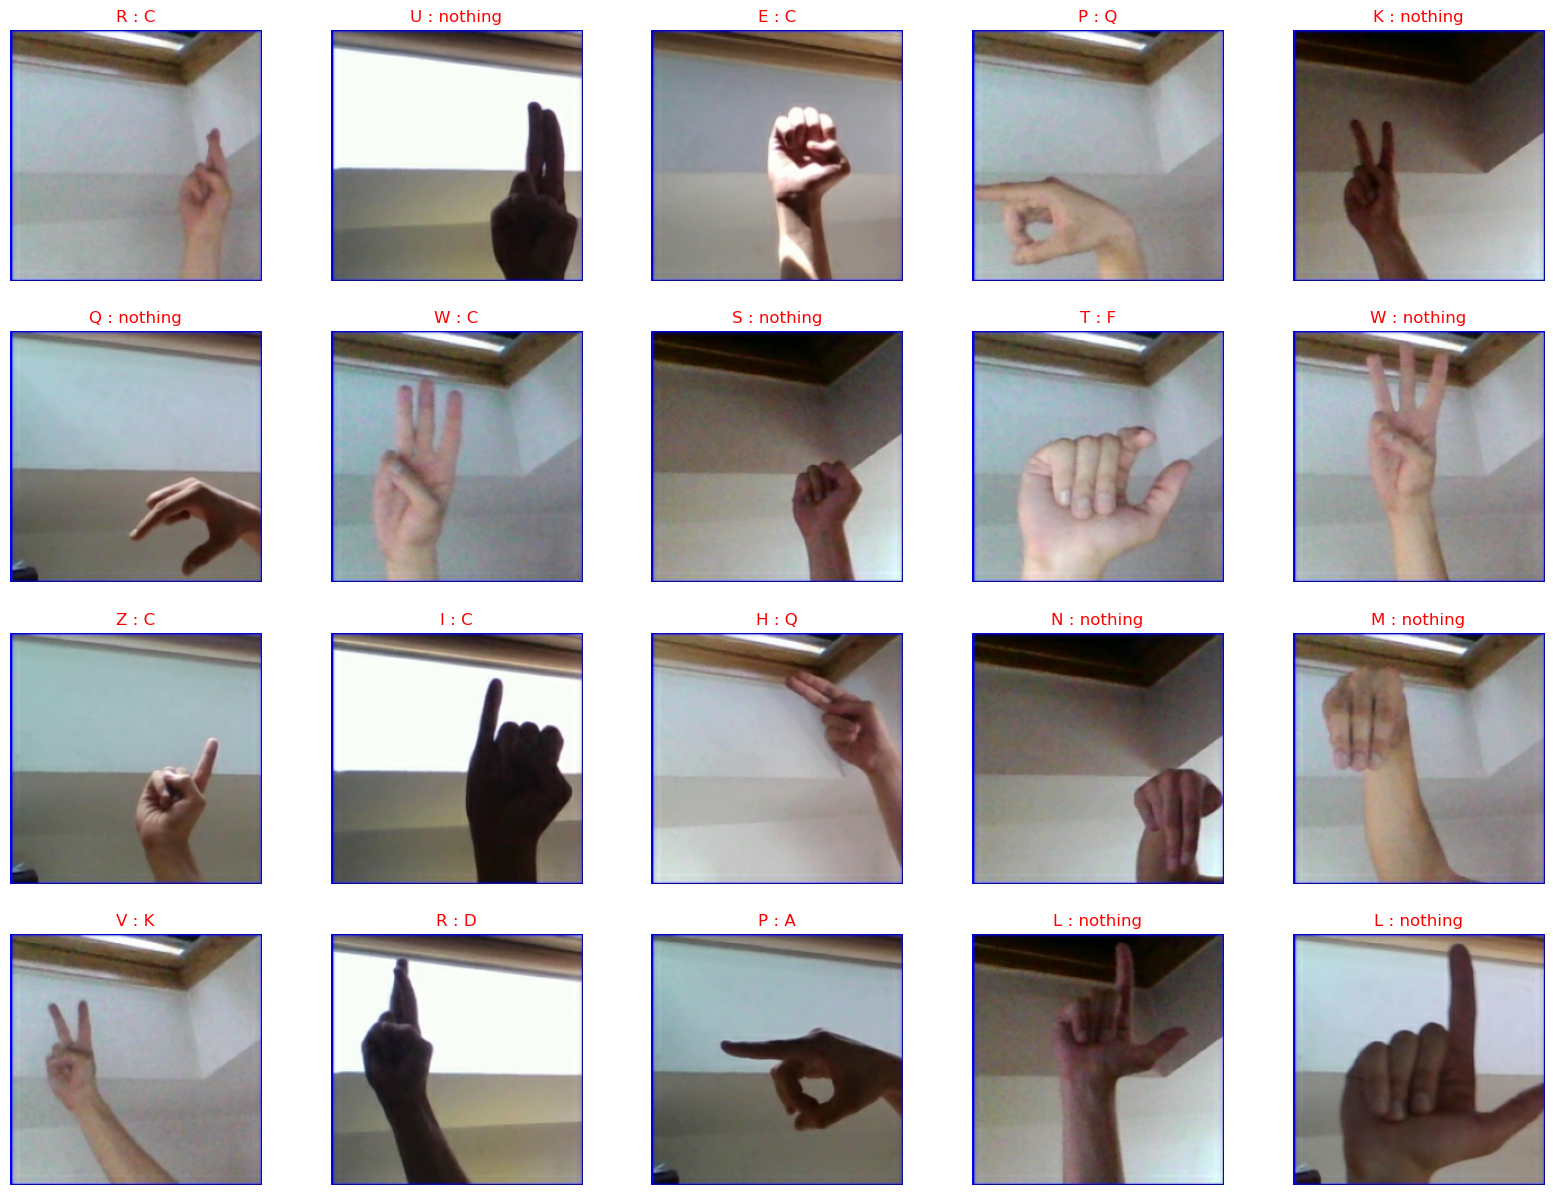

In [38]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we showed how you can use **fine-tuning** to make adjustments to the weights in the last few layers of a pre-trained convolutional base to improve the validation accuracy of the model. This is a very common technique that is used to leverage pre-existing models for new datasets. When using this approach, it is recommended that you first train the dense classifier only and then un-freeze the layers in the convolutional base that you wish to fine-tune and the model again (including the dense classifier) at a lower learning rate. 